In [1173]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
import random
import warnings
warnings.filterwarnings("ignore")

# Data Cleaning

## 1.Ranking 

In [1174]:
#read matches.csv (past World Cup matches)
matches = pd.read_csv("worldcup-master/data-csv/matches.csv")
matches.head(5)

,key_id,tournament_id,tournament_name,match_id,match_name,stage_name,group_name,group_stage,knockout_stage,replayed,...,away_team_score_margin,extra_time,penalty_shootout,score_penalties,home_team_score_penalties,away_team_score_penalties,result,home_team_win,away_team_win,draw
0,1,WC-1930,1930 FIFA World Cup,M-1930-01,France v Mexico,group stage,Group 1,1,0,0,...,-3,0,0,0-0,0,0,home team win,1,0,0
1,2,WC-1930,1930 FIFA World Cup,M-1930-02,United States v Belgium,group stage,Group 4,1,0,0,...,-3,0,0,0-0,0,0,home team win,1,0,0
2,3,WC-1930,1930 FIFA World Cup,M-1930-03,Yugoslavia v Brazil,group stage,Group 2,1,0,0,...,-1,0,0,0-0,0,0,home team win,1,0,0
3,4,WC-1930,1930 FIFA World Cup,M-1930-04,Romania v Peru,group stage,Group 3,1,0,0,...,-2,0,0,0-0,0,0,home team win,1,0,0
4,5,WC-1930,1930 FIFA World Cup,M-1930-05,Argentina v France,group stage,Group 1,1,0,0,...,-1,0,0,0-0,0,0,home team win,1,0,0


In [1175]:
#select matches that happened after or during 2010 World Cup
World_Cup_201018 = matches[matches['match_date'] >= '2010-01-01']
World_Cup_201018.head(5)

,key_id,tournament_id,tournament_name,match_id,match_name,stage_name,group_name,group_stage,knockout_stage,replayed,...,away_team_score_margin,extra_time,penalty_shootout,score_penalties,home_team_score_penalties,away_team_score_penalties,result,home_team_win,away_team_win,draw
708,709,WC-2010,2010 FIFA World Cup,M-2010-01,South Africa v Mexico,group stage,Group A,1,0,0,...,0,0,0,0-0,0,0,draw,0,0,1
709,710,WC-2010,2010 FIFA World Cup,M-2010-02,Uruguay v France,group stage,Group A,1,0,0,...,0,0,0,0-0,0,0,draw,0,0,1
710,711,WC-2010,2010 FIFA World Cup,M-2010-03,South Korea v Greece,group stage,Group B,1,0,0,...,-2,0,0,0-0,0,0,home team win,1,0,0
711,712,WC-2010,2010 FIFA World Cup,M-2010-04,Argentina v Nigeria,group stage,Group B,1,0,0,...,-1,0,0,0-0,0,0,home team win,1,0,0
712,713,WC-2010,2010 FIFA World Cup,M-2010-05,England v United States,group stage,Group C,1,0,0,...,0,0,0,0-0,0,0,draw,0,0,1


In [1176]:
#remove features
World_Cup_201018_cleaned = World_Cup_201018[['tournament_id', 'match_id', 'match_name', 'stage_name',
                                            'group_name', 'match_date', 'home_team_name', 'home_team_code',
                                             'away_team_name','away_team_code',
                                            'home_team_score', 'away_team_score', 'home_team_win', 'away_team_win']]
World_Cup_201018_cleaned['year'] = [x[:4] for x in World_Cup_201018['match_date']]
#World_Cup_201018_cleaned['month'] = [x[5:7] for x in World_Cup_201018['match_date']]
World_Cup_201018_cleaned.head(5)

,tournament_id,match_id,match_name,stage_name,group_name,match_date,home_team_name,home_team_code,away_team_name,away_team_code,home_team_score,away_team_score,home_team_win,away_team_win,year
708,WC-2010,M-2010-01,South Africa v Mexico,group stage,Group A,2010-06-11,South Africa,ZAF,Mexico,MEX,1,1,0,0,2010
709,WC-2010,M-2010-02,Uruguay v France,group stage,Group A,2010-06-11,Uruguay,URY,France,FRA,0,0,0,0,2010
710,WC-2010,M-2010-03,South Korea v Greece,group stage,Group B,2010-06-12,South Korea,KOR,Greece,GRC,2,0,1,0,2010
711,WC-2010,M-2010-04,Argentina v Nigeria,group stage,Group B,2010-06-12,Argentina,ARG,Nigeria,NGA,1,0,1,0,2010
712,WC-2010,M-2010-05,England v United States,group stage,Group C,2010-06-12,England,ENG,United States,USA,1,1,0,0,2010


In [1177]:
#read the ranking data
ranking = pd.read_csv("fifa_ranking-2022-10-06.csv")
ranking['year'] = [x[:4] for x in ranking['rank_date']]
#ranking['month'] = [x[5:7] for x in ranking['rank_date']]
ranking = ranking[['rank', 'country_full', 'year']]
#take the median ranking of the year
ranking = ranking.groupby(['country_full', 'year']).median().reset_index()
#ranking['country_abrv'] = ranking_temp['country_abrv']
#ranking['country_full'].unique()

In [1178]:
#It turns out South Korea, North Korea, Ivory Coast, United States, and Iran could not be matched
ranking["country_full"] = ranking["country_full"].replace("IR Iran", "Iran").replace("Korea Republic", "South Korea").replace("USA", "United States").replace("Côte d'Ivoire", 'Ivory Coast').replace('Korea DPR', 'North Korea')

In [1179]:
#add home_team_ranking
world_cup_201018_ranked = World_Cup_201018_cleaned.merge(ranking,
               left_on=['home_team_name', 'year'], right_on=['country_full', 'year'], how='left')
world_cup_201018_ranked = world_cup_201018_ranked.rename(columns={"rank": "home_team_rank"}).drop("country_full", axis = 1)
#add away_team_ranking
world_cup_201018_ranked = world_cup_201018_ranked.merge(ranking,
               left_on=['away_team_name', 'year'], right_on=['country_full', 'year'], how='left')
world_cup_201018_ranked = world_cup_201018_ranked.rename(columns={"rank": "away_team_rank"}).drop("country_full", axis = 1)
world_cup_201018_ranked[world_cup_201018_ranked['away_team_rank'].isna()]
world_cup_201018_ranked = world_cup_201018_ranked.dropna() #dropna
world_cup_201018_ranked.head(5)

,tournament_id,match_id,match_name,stage_name,group_name,match_date,home_team_name,home_team_code,away_team_name,away_team_code,home_team_score,away_team_score,home_team_win,away_team_win,year,home_team_rank,away_team_rank
0,WC-2010,M-2010-01,South Africa v Mexico,group stage,Group A,2010-06-11,South Africa,ZAF,Mexico,MEX,1,1,0,0,2010,66.0,24.0
1,WC-2010,M-2010-02,Uruguay v France,group stage,Group A,2010-06-11,Uruguay,URY,France,FRA,0,0,0,0,2010,7.0,18.0
2,WC-2010,M-2010-03,South Korea v Greece,group stage,Group B,2010-06-12,South Korea,KOR,Greece,GRC,2,0,1,0,2010,44.0,12.0
3,WC-2010,M-2010-04,Argentina v Nigeria,group stage,Group B,2010-06-12,Argentina,ARG,Nigeria,NGA,1,0,1,0,2010,5.0,30.0
4,WC-2010,M-2010-05,England v United States,group stage,Group C,2010-06-12,England,ENG,United States,USA,1,1,0,0,2010,7.0,18.0


In [1180]:
#presentation use only
#world_cup_201018_ranked[['home_team_name', 'away_team_name', 'home_team_rank', 'away_team_rank']].head(5)

## 2.Age  &  Award Winners

In [1181]:
start_age = world_cup_201018_ranked

In [1182]:
players = pd.read_csv("worldcup-master/data-csv/players.csv")
#players

In [1183]:
players_appearance = pd.read_csv("worldcup-master/data-csv/player_appearances.csv")
players_appearance = players_appearance[['tournament_id', 'match_id', 'match_name', 'match_date',
                                        'stage_name', 'team_id', 'team_name', 'team_code', 'player_id',
                                        'family_name', 'given_name']]
players_appearance['match_year'] = np.array([x[:4] for x in players_appearance['match_date']]).astype(int)
players_appearance = players_appearance[players_appearance['match_year'] >= 2010]
players_appearance.head(5)

,tournament_id,match_id,match_name,match_date,stage_name,team_id,team_name,team_code,player_id,family_name,given_name,match_year
13289,WC-2010,M-2010-01,South Africa v Mexico,2010-06-11,group stage,T-67,South Africa,ZAF,P-06180,Gaxa,Siboniso,2010
13290,WC-2010,M-2010-01,South Africa v Mexico,2010-06-11,group stage,T-67,South Africa,ZAF,P-04922,Mokoena,Aaron,2010
13291,WC-2010,M-2010-01,South Africa v Mexico,2010-06-11,group stage,T-67,South Africa,ZAF,P-05473,Tshabalala,Siphiwe,2010
13292,WC-2010,M-2010-01,South Africa v Mexico,2010-06-11,group stage,T-67,South Africa,ZAF,P-08963,Mphela,Katlego,2010
13293,WC-2010,M-2010-01,South Africa v Mexico,2010-06-11,group stage,T-67,South Africa,ZAF,P-01977,Pienaar,Steven,2010


In [1184]:
#calculate the age of players during appearances
player_df = players[['player_id', 'family_name', 'given_name', 'birth_date','list_tournaments']]
player_df['total appearances in World Cup'] = [len(x.split(', ')) for x in player_df['list_tournaments']]
player_df = player_df.dropna() #only dropped 1 row of nan
player_df = player_df[player_df['birth_date'] != 'not available']  #77 rows of not available birth date
player_df['birth_year'] = np.array([x[:4] for x in player_df['birth_date']]).astype(int)

In [1185]:
#add award winners
award_winners = pd.read_csv("worldcup-master/data-csv/award_winners.csv")
award_winners = award_winners[['player_id','family_name', 'given_name']]

#add a column of 1 to denote that the player is an award winner
award_winners['award_won'] = np.ones(len(award_winners)).astype(int)
award_winners = award_winners.groupby(['player_id','family_name', 'given_name']).sum().reset_index()

award_winners.head(5)

,player_id,family_name,given_name,award_won
0,P-00008,Rivaldo,not applicable,1
1,P-00009,Jerković,Dražan,1
2,P-00132,Buffon,Gianluigi,1
3,P-00643,Fontaine,Just,1
4,P-00724,Cea,Pedro,1


In [1186]:
#merge player_df and award_winners
player_df = player_df.merge(award_winners,
               left_on=['player_id', 'family_name', 'given_name'],
               right_on=['player_id', 'family_name', 'given_name'], how='left')

In [1187]:
#fill in NaN value with 0
player_df = player_df.replace(np.nan,0)
player_df.head(5)

,player_id,family_name,given_name,birth_date,list_tournaments,total appearances in World Cup,birth_year,award_won
0,P-05074,A'Court,Alan,1934-09-30,1958,1,1934,0.0
1,P-00942,Abadzhiev,Stefan,1934-07-03,1966,1,1934,0.0
2,P-03051,Abalo,Jean-Paul,1975-06-26,2006,1,1975,0.0
3,P-03371,Abanda,Patrice,1978-08-03,1998,1,1978,0.0
4,P-04977,Abate,Ignazio,1986-11-12,2014,1,1986,0.0


In [1188]:
players_appearance_merged = players_appearance.merge(player_df,
               left_on=['player_id', 'family_name', 'given_name'],
               right_on=['player_id', 'family_name', 'given_name'], how='left')

In [1189]:
players_appearance_merged['age'] = players_appearance_merged['match_year'] - players_appearance_merged['birth_year']
players_appearance_merged.head(5)

,tournament_id,match_id,match_name,match_date,stage_name,team_id,team_name,team_code,player_id,family_name,given_name,match_year,birth_date,list_tournaments,total appearances in World Cup,birth_year,award_won,age
0,WC-2010,M-2010-01,South Africa v Mexico,2010-06-11,group stage,T-67,South Africa,ZAF,P-06180,Gaxa,Siboniso,2010,1984-04-06,2010,1,1984,0.0,26
1,WC-2010,M-2010-01,South Africa v Mexico,2010-06-11,group stage,T-67,South Africa,ZAF,P-04922,Mokoena,Aaron,2010,1980-11-25,"2002, 2010",2,1980,0.0,30
2,WC-2010,M-2010-01,South Africa v Mexico,2010-06-11,group stage,T-67,South Africa,ZAF,P-05473,Tshabalala,Siphiwe,2010,1984-09-25,2010,1,1984,0.0,26
3,WC-2010,M-2010-01,South Africa v Mexico,2010-06-11,group stage,T-67,South Africa,ZAF,P-08963,Mphela,Katlego,2010,1984-11-29,2010,1,1984,0.0,26
4,WC-2010,M-2010-01,South Africa v Mexico,2010-06-11,group stage,T-67,South Africa,ZAF,P-01977,Pienaar,Steven,2010,1982-03-17,"2002, 2010",2,1982,0.0,28


In [1190]:
#take the average of each teams' age for all games and sum up the awards won
players_appearance_averaged = players_appearance_merged.groupby(['team_name', 'match_id']).agg({'total appearances in World Cup':'mean', 
                                                                                                'age':'mean', 
                                                                                                'award_won': 'sum'}).reset_index()
players_appearance_averaged = players_appearance_averaged.rename(columns={'age':'average age', 
                                                                          'total appearances in World Cup': 'averaged appearances in World Cup'})
players_appearance_averaged.head()

,team_name,match_id,averaged appearances in World Cup,average age,award_won
0,Algeria,M-2010-06,1.285714,27.000000,0.0
1,Algeria,M-2010-23,1.428571,25.642857,0.0
2,Algeria,M-2010-38,1.357143,26.857143,0.0
3,Algeria,M-2014-15,1.357143,26.285714,0.0
4,Algeria,M-2014-31,1.428571,26.500000,0.0


In [1191]:
#take the average of each teams' age for all games
#players_appearance_averaged = players_appearance_merged.groupby(['team_name', 'match_id']).mean().reset_index().drop('birth_year', axis=1)
#players_appearance_averaged = players_appearance_averaged.rename(columns={'age':'average age', 
#                                                                          'total appearances in World Cup': 'averaged appearances in World Cup'})
#players_appearance_averaged.head()

In [1192]:
#merged home teams' total appearances and average age
start_age_merged = start_age.merge(players_appearance_averaged,
               left_on=['match_id', 'home_team_name'],
               right_on=['match_id', 'team_name'], how='left')
start_age_merged = start_age_merged.drop(['team_name'], axis=1)
start_age_merged = start_age_merged.rename(columns={"averaged appearances in World Cup":"home avg appearances in World Cup",
                                                   "average age":"home avg age",
                                                   'award_won':'home award won'})

#merged away teams' total appearances and average age
start_age_merged = start_age_merged.merge(players_appearance_averaged,
               left_on=['match_id', 'away_team_name'],
               right_on=['match_id', 'team_name'], how='left')
start_age_merged = start_age_merged.drop(['team_name'], axis=1)
start_age_merged = start_age_merged.rename(columns={"averaged appearances in World Cup":"away avg appearances in World Cup",
                                                   "average age":"away avg age",
                                                   'award_won':'away award won'})
start_age_merged.head(5)

,tournament_id,match_id,match_name,stage_name,group_name,match_date,home_team_name,home_team_code,away_team_name,away_team_code,...,away_team_win,year,home_team_rank,away_team_rank,home avg appearances in World Cup,home avg age,home award won,away avg appearances in World Cup,away avg age,away award won
0,WC-2010,M-2010-01,South Africa v Mexico,group stage,Group A,2010-06-11,South Africa,ZAF,Mexico,MEX,...,0,2010,66.0,24.0,1.153846,26.307692,0.0,2.785714,28.071429,0.0
1,WC-2010,M-2010-02,Uruguay v France,group stage,Group A,2010-06-11,Uruguay,URY,France,FRA,...,0,2010,7.0,18.0,2.142857,27.214286,1.0,1.857143,28.285714,0.0
2,WC-2010,M-2010-03,South Korea v Greece,group stage,Group B,2010-06-12,South Korea,KOR,Greece,GRC,...,0,2010,44.0,12.0,1.928571,27.000000,0.0,1.571429,28.428571,0.0
3,WC-2010,M-2010-04,Argentina v Nigeria,group stage,Group B,2010-06-12,Argentina,ARG,Nigeria,NGA,...,0,2010,5.0,30.0,2.428571,27.714286,1.0,1.357143,26.428571,0.0
4,WC-2010,M-2010-05,England v United States,group stage,Group C,2010-06-12,England,ENG,United States,USA,...,0,2010,7.0,18.0,2.071429,28.714286,0.0,1.923077,27.461538,1.0


In [1193]:
#presentation use only
#start_age_merged[['home_team_name', 'home_team_rank', 'home avg appearances in World Cup', 'home avg age', 
#                  'home award won',
#                 'away_team_name', 'away_team_rank', 'away avg appearances in World Cup', 'away avg age', 
#                  'away award won']]

## 3.Manager

In [1194]:
start_manager = start_age_merged
start_manager.head(5)

,tournament_id,match_id,match_name,stage_name,group_name,match_date,home_team_name,home_team_code,away_team_name,away_team_code,...,away_team_win,year,home_team_rank,away_team_rank,home avg appearances in World Cup,home avg age,home award won,away avg appearances in World Cup,away avg age,away award won
0,WC-2010,M-2010-01,South Africa v Mexico,group stage,Group A,2010-06-11,South Africa,ZAF,Mexico,MEX,...,0,2010,66.0,24.0,1.153846,26.307692,0.0,2.785714,28.071429,0.0
1,WC-2010,M-2010-02,Uruguay v France,group stage,Group A,2010-06-11,Uruguay,URY,France,FRA,...,0,2010,7.0,18.0,2.142857,27.214286,1.0,1.857143,28.285714,0.0
2,WC-2010,M-2010-03,South Korea v Greece,group stage,Group B,2010-06-12,South Korea,KOR,Greece,GRC,...,0,2010,44.0,12.0,1.928571,27.000000,0.0,1.571429,28.428571,0.0
3,WC-2010,M-2010-04,Argentina v Nigeria,group stage,Group B,2010-06-12,Argentina,ARG,Nigeria,NGA,...,0,2010,5.0,30.0,2.428571,27.714286,1.0,1.357143,26.428571,0.0
4,WC-2010,M-2010-05,England v United States,group stage,Group C,2010-06-12,England,ENG,United States,USA,...,0,2010,7.0,18.0,2.071429,28.714286,0.0,1.923077,27.461538,1.0


In [1195]:
#load managers appearances data
manager_appearances = pd.read_csv("worldcup-master/data-csv/manager_appearances.csv")
manager_appearances = manager_appearances[['match_id', 'team_name', 'family_name', 'given_name']]
manager_appearances.head(5)

,match_id,team_name,family_name,given_name
0,M-1930-01,France,Caudron,Raoul
1,M-1930-01,Mexico,Luque de Serrallonga,Juan
2,M-1930-02,United States,Millar,Robert
3,M-1930-02,Belgium,Goetinck,Hector
4,M-1930-03,Yugoslavia,Simonović,Boško


In [1196]:
#merge home manager appearances data with match data
start_manager_merged = start_manager.merge(manager_appearances,
               left_on=['match_id', 'home_team_name'],
               right_on=['match_id', 'team_name'], how='left')
start_manager_merged = start_manager_merged.drop(['team_name'], axis=1)
start_manager_merged = start_manager_merged.rename(columns={"family_name":"home manager family name",
                                                   "given_name":"home manager given name"})

#merge away manager appearances data with match data
start_manager_merged = start_manager_merged.merge(manager_appearances,
               left_on=['match_id', 'away_team_name'],
               right_on=['match_id', 'team_name'], how='left')
start_manager_merged = start_manager_merged.drop(['team_name'], axis=1)
start_manager_merged = start_manager_merged.rename(columns={"family_name":"away manager family name",
                                                   "given_name":"away manager given name"})

start_manager_merged.head(5)

,tournament_id,match_id,match_name,stage_name,group_name,match_date,home_team_name,home_team_code,away_team_name,away_team_code,...,home avg appearances in World Cup,home avg age,home award won,away avg appearances in World Cup,away avg age,away award won,home manager family name,home manager given name,away manager family name,away manager given name
0,WC-2010,M-2010-01,South Africa v Mexico,group stage,Group A,2010-06-11,South Africa,ZAF,Mexico,MEX,...,1.153846,26.307692,0.0,2.785714,28.071429,0.0,Parreira,Carlos Alberto,Aguirre,Javier
1,WC-2010,M-2010-02,Uruguay v France,group stage,Group A,2010-06-11,Uruguay,URY,France,FRA,...,2.142857,27.214286,1.0,1.857143,28.285714,0.0,Tabárez,Óscar,Domenech,Raymond
2,WC-2010,M-2010-03,South Korea v Greece,group stage,Group B,2010-06-12,South Korea,KOR,Greece,GRC,...,1.928571,27.000000,0.0,1.571429,28.428571,0.0,Huh,Jung-moo,Rehhagel,Otto
3,WC-2010,M-2010-04,Argentina v Nigeria,group stage,Group B,2010-06-12,Argentina,ARG,Nigeria,NGA,...,2.428571,27.714286,1.0,1.357143,26.428571,0.0,Maradona,Diego,Lagerbäck,Lars
4,WC-2010,M-2010-05,England v United States,group stage,Group C,2010-06-12,England,ENG,United States,USA,...,2.071429,28.714286,0.0,1.923077,27.461538,1.0,Capello,Fabio,Bradley,Bob


## 4.Goals Scored and Against in Last 5 World Cup Matches

In [1197]:
start_goal = start_manager_merged

In [1198]:
matches_sorted = matches.sort_values('match_date')
matches_sorted.columns

Index(['key_id', 'tournament_id', 'tournament_name', 'match_id', 'match_name',
       'stage_name', 'group_name', 'group_stage', 'knockout_stage', 'replayed',
       'replay', 'match_date', 'match_time', 'stadium_id', 'stadium_name',
       'city_name', 'country_name', 'home_team_id', 'home_team_name',
       'home_team_code', 'away_team_id', 'away_team_name', 'away_team_code',
       'score', 'home_team_score', 'away_team_score', 'home_team_score_margin',
       'away_team_score_margin', 'extra_time', 'penalty_shootout',
       'score_penalties', 'home_team_score_penalties',
       'away_team_score_penalties', 'result', 'home_team_win', 'away_team_win',
       'draw'],
      dtype='object')

In [1199]:
#home team records

home_goal_scored = []
home_goal_against = []
home_wins = []
home_previous_games_count_max_5 = []

for i in range(len(start_goal)):
    test_match = start_goal['match_id'][i]
    test_team = start_goal['home_team_name'][i]
    prev_matches = matches_sorted.loc[(matches_sorted['match_id'] < test_match) 
                            & ((matches_sorted['home_team_name'] == test_team) |
                               (matches_sorted['away_team_name'] == test_team)), :]

    
    if len(prev_matches) == 0:
        home_goal_scored.append(0)
        home_goal_against.append(0)
        home_wins.append(0)
        home_previous_games_count_max_5.append(0)
        
    else:
        last_5 = prev_matches.tail(5)
        home_previous_games_count_max_5.append(len(last_5))
        
        home_team_index = last_5['home_team_name'] == test_team
        away_team_index = last_5['away_team_name'] == test_team
        
        last_5_away = last_5.loc[away_team_index, :]
        if len(last_5_away) == 0:
            last_5_away = np.array([0, 0, 0])
        else:
            last_5_away = last_5_away.groupby('away_team_name')['away_team_score', 'home_team_score',
                                                        'away_team_win'].sum().to_numpy()[0]
        last_5_home = last_5.loc[home_team_index, :]
        if len(last_5_home) == 0:
            last_5_home = np.array([0, 0, 0])
        else:
            last_5_home = last_5_home.groupby('home_team_name')['home_team_score', 'away_team_score',
                                                        'home_team_win'].sum().to_numpy()[0]

        results = last_5_home + last_5_away

        home_goal_scored.append(results[0])
        home_goal_against.append(results[1])
        home_wins.append(results[2])    

In [1200]:
#away team records

away_goal_scored = []
away_goal_against = []
away_wins = []
away_previous_games_count_max_5 = []

for i in range(len(start_goal)):
    test_match = start_goal['match_id'][i]
    test_team = start_goal['away_team_name'][i]
    prev_matches = matches_sorted.loc[(matches_sorted['match_id'] < test_match) 
                            & ((matches_sorted['home_team_name'] == test_team) |
                               (matches_sorted['away_team_name'] == test_team)), :]

    
    if len(prev_matches) == 0:
        away_goal_scored.append(0)
        away_goal_against.append(0)
        away_wins.append(0)
        away_previous_games_count_max_5.append(0)
        
    else:
        last_5 = prev_matches.tail(5)
        away_previous_games_count_max_5.append(len(last_5))
        
        home_team_index = last_5['home_team_name'] == test_team
        away_team_index = last_5['away_team_name'] == test_team
        
        last_5_away = last_5.loc[away_team_index, :]
        if len(last_5_away) == 0:
            last_5_away = np.array([0, 0, 0])
        else:
            last_5_away = last_5_away.groupby('away_team_name')['away_team_score', 'home_team_score',
                                                        'away_team_win'].sum().to_numpy()[0]
        last_5_home = last_5.loc[home_team_index, :]
        if len(last_5_home) == 0:
            last_5_home = np.array([0, 0, 0])
        else:
            last_5_home = last_5_home.groupby('home_team_name')['home_team_score', 'away_team_score',
                                                        'home_team_win'].sum().to_numpy()[0]

        results = last_5_home + last_5_away

        away_goal_scored.append(results[0])
        away_goal_against.append(results[1])
        away_wins.append(results[2])    

In [1201]:
start_goal_merged = start_goal
start_goal_merged['home_team_last_5_games_goals_scored'] = home_goal_scored
start_goal_merged['home_team_last_5_games_goals_against'] = home_goal_against
start_goal_merged['home_team_last_5_games_wins'] = home_wins
start_goal_merged['home_team_last_5_games_played'] = home_previous_games_count_max_5

start_goal_merged['away_team_last_5_games_goals_scored'] = away_goal_scored
start_goal_merged['away_team_last_5_games_goals_against'] = away_goal_against
start_goal_merged['away_team_last_5_games_wins'] = away_wins
start_goal_merged['away_team_last_5_games_played'] = away_previous_games_count_max_5

start_goal_merged.head(5)

,tournament_id,match_id,match_name,stage_name,group_name,match_date,home_team_name,home_team_code,away_team_name,away_team_code,...,away manager family name,away manager given name,home_team_last_5_games_goals_scored,home_team_last_5_games_goals_against,home_team_last_5_games_wins,home_team_last_5_games_played,away_team_last_5_games_goals_scored,away_team_last_5_games_goals_against,away_team_last_5_games_wins,away_team_last_5_games_played
0,WC-2010,M-2010-01,South Africa v Mexico,group stage,Group A,2010-06-11,South Africa,ZAF,Mexico,MEX,...,Aguirre,Javier,8,8,1,5,5,7,1,5
1,WC-2010,M-2010-02,Uruguay v France,group stage,Group A,2010-06-11,Uruguay,URY,France,FRA,...,Domenech,Raymond,5,7,1,5,8,2,4,5
2,WC-2010,M-2010-03,South Korea v Greece,group stage,Group B,2010-06-12,South Korea,KOR,Greece,GRC,...,Rehhagel,Otto,5,8,1,5,0,10,0,3
3,WC-2010,M-2010-04,Argentina v Nigeria,group stage,Group B,2010-06-12,Argentina,ARG,Nigeria,NGA,...,Lagerbäck,Lars,11,3,3,5,3,10,0,5
4,WC-2010,M-2010-05,England v United States,group stage,Group C,2010-06-12,England,ENG,United States,USA,...,Bradley,Bob,6,2,3,5,4,7,1,5


## 5.Export Data 

In [1202]:
cleaned_df = start_goal_merged
#cleaned_df.to_csv("train_test_df.csv")

# EDA

In [1203]:
#home team win is highly correlated with away team win as expected
#solution: double the sample size by creating two rows per matches, one for the away and one for the home team.
#There is no difference between away and home during World Cup

In [1204]:
#home_team_df
home_team_df = cleaned_df
home_team_df['rank dif'] = home_team_df['home_team_rank'] - home_team_df['away_team_rank']
home_team_df['World Cup avg appearance dif'] = home_team_df['home avg appearances in World Cup'] - home_team_df['away avg appearances in World Cup']
home_team_df['avg age dif'] = home_team_df['home avg age'] - home_team_df['away avg age']
home_team_df['award dif'] = home_team_df['home award won'] - home_team_df['away award won']
home_team_df = home_team_df.drop(['away manager family name', 'away manager given name',
                                'away_team_rank', 'away avg appearances in World Cup', 'away_team_win', 
                                  'away award won', 'away avg age', 'away_team_last_5_games_goals_scored',
                                  'away_team_last_5_games_goals_against', 'away_team_last_5_games_wins',
                                  'away_team_last_5_games_played', 'away_team_name', 'away_team_code', 
                                  'home_team_score', 'away_team_score'
                                  
                               ], axis=1)
#home_team_df = home_team_df.rename(columns={"away_team_score":"goal against",
#                                                   "home_team_score":"goal scored"})
home_team_df.head(5)

,tournament_id,match_id,match_name,stage_name,group_name,match_date,home_team_name,home_team_code,home_team_win,year,...,home manager family name,home manager given name,home_team_last_5_games_goals_scored,home_team_last_5_games_goals_against,home_team_last_5_games_wins,home_team_last_5_games_played,rank dif,World Cup avg appearance dif,avg age dif,award dif
0,WC-2010,M-2010-01,South Africa v Mexico,group stage,Group A,2010-06-11,South Africa,ZAF,0,2010,...,Parreira,Carlos Alberto,8,8,1,5,42.0,-1.631868,-1.763736,0.0
1,WC-2010,M-2010-02,Uruguay v France,group stage,Group A,2010-06-11,Uruguay,URY,0,2010,...,Tabárez,Óscar,5,7,1,5,-11.0,0.285714,-1.071429,1.0
2,WC-2010,M-2010-03,South Korea v Greece,group stage,Group B,2010-06-12,South Korea,KOR,1,2010,...,Huh,Jung-moo,5,8,1,5,32.0,0.357143,-1.428571,0.0
3,WC-2010,M-2010-04,Argentina v Nigeria,group stage,Group B,2010-06-12,Argentina,ARG,1,2010,...,Maradona,Diego,11,3,3,5,-25.0,1.071429,1.285714,1.0
4,WC-2010,M-2010-05,England v United States,group stage,Group C,2010-06-12,England,ENG,0,2010,...,Capello,Fabio,6,2,3,5,-11.0,0.148352,1.252747,-1.0


In [1205]:
home_team_df.columns

Index(['tournament_id', 'match_id', 'match_name', 'stage_name', 'group_name',
       'match_date', 'home_team_name', 'home_team_code', 'home_team_win',
       'year', 'home_team_rank', 'home avg appearances in World Cup',
       'home avg age', 'home award won', 'home manager family name',
       'home manager given name', 'home_team_last_5_games_goals_scored',
       'home_team_last_5_games_goals_against', 'home_team_last_5_games_wins',
       'home_team_last_5_games_played', 'rank dif',
       'World Cup avg appearance dif', 'avg age dif', 'award dif'],
      dtype='object')

In [1206]:
#away_team_df
away_team_df = cleaned_df
away_team_df['rank dif'] = away_team_df['away_team_rank'] - away_team_df['home_team_rank']
away_team_df['World Cup avg appearance dif'] = away_team_df['away avg appearances in World Cup'] - away_team_df['home avg appearances in World Cup']
away_team_df['avg age dif'] = away_team_df['away avg age'] - away_team_df['home avg age']
away_team_df['award dif'] = away_team_df['away award won'] - away_team_df['home award won']
away_team_df = away_team_df.drop(['home manager family name', 'home manager given name',
                                'home_team_rank', 'home avg appearances in World Cup', 'home_team_win', 
                                  'home award won', 'home avg age', 'home_team_last_5_games_goals_scored',
                                  'home_team_last_5_games_goals_against', 'home_team_last_5_games_wins',
                                  'home_team_last_5_games_played', 'home_team_name', 'home_team_code', 
                                  'home_team_score', 'away_team_score'
                                  
                               ], axis=1)
#home_team_df = home_team_df.rename(columns={"away_team_score":"goal against",
#                                                   "home_team_score":"goal scored"})
away_team_df.head(5)

,tournament_id,match_id,match_name,stage_name,group_name,match_date,away_team_name,away_team_code,away_team_win,year,...,away manager family name,away manager given name,away_team_last_5_games_goals_scored,away_team_last_5_games_goals_against,away_team_last_5_games_wins,away_team_last_5_games_played,rank dif,World Cup avg appearance dif,avg age dif,award dif
0,WC-2010,M-2010-01,South Africa v Mexico,group stage,Group A,2010-06-11,Mexico,MEX,0,2010,...,Aguirre,Javier,5,7,1,5,-42.0,1.631868,1.763736,0.0
1,WC-2010,M-2010-02,Uruguay v France,group stage,Group A,2010-06-11,France,FRA,0,2010,...,Domenech,Raymond,8,2,4,5,11.0,-0.285714,1.071429,-1.0
2,WC-2010,M-2010-03,South Korea v Greece,group stage,Group B,2010-06-12,Greece,GRC,0,2010,...,Rehhagel,Otto,0,10,0,3,-32.0,-0.357143,1.428571,0.0
3,WC-2010,M-2010-04,Argentina v Nigeria,group stage,Group B,2010-06-12,Nigeria,NGA,0,2010,...,Lagerbäck,Lars,3,10,0,5,25.0,-1.071429,-1.285714,-1.0
4,WC-2010,M-2010-05,England v United States,group stage,Group C,2010-06-12,United States,USA,0,2010,...,Bradley,Bob,4,7,1,5,11.0,-0.148352,-1.252747,1.0


In [1207]:
away_team_df.columns

Index(['tournament_id', 'match_id', 'match_name', 'stage_name', 'group_name',
       'match_date', 'away_team_name', 'away_team_code', 'away_team_win',
       'year', 'away_team_rank', 'away avg appearances in World Cup',
       'away avg age', 'away award won', 'away manager family name',
       'away manager given name', 'away_team_last_5_games_goals_scored',
       'away_team_last_5_games_goals_against', 'away_team_last_5_games_wins',
       'away_team_last_5_games_played', 'rank dif',
       'World Cup avg appearance dif', 'avg age dif', 'award dif'],
      dtype='object')

In [1208]:
#concate away team_df and home_team_df
away_team_df.columns = home_team_df.columns
all_teams_df = pd.concat([home_team_df, away_team_df], axis=0, ignore_index=True)
all_teams_df.head(5)

,tournament_id,match_id,match_name,stage_name,group_name,match_date,home_team_name,home_team_code,home_team_win,year,...,home manager family name,home manager given name,home_team_last_5_games_goals_scored,home_team_last_5_games_goals_against,home_team_last_5_games_wins,home_team_last_5_games_played,rank dif,World Cup avg appearance dif,avg age dif,award dif
0,WC-2010,M-2010-01,South Africa v Mexico,group stage,Group A,2010-06-11,South Africa,ZAF,0,2010,...,Parreira,Carlos Alberto,8,8,1,5,42.0,-1.631868,-1.763736,0.0
1,WC-2010,M-2010-02,Uruguay v France,group stage,Group A,2010-06-11,Uruguay,URY,0,2010,...,Tabárez,Óscar,5,7,1,5,-11.0,0.285714,-1.071429,1.0
2,WC-2010,M-2010-03,South Korea v Greece,group stage,Group B,2010-06-12,South Korea,KOR,1,2010,...,Huh,Jung-moo,5,8,1,5,32.0,0.357143,-1.428571,0.0
3,WC-2010,M-2010-04,Argentina v Nigeria,group stage,Group B,2010-06-12,Argentina,ARG,1,2010,...,Maradona,Diego,11,3,3,5,-25.0,1.071429,1.285714,1.0
4,WC-2010,M-2010-05,England v United States,group stage,Group C,2010-06-12,England,ENG,0,2010,...,Capello,Fabio,6,2,3,5,-11.0,0.148352,1.252747,-1.0


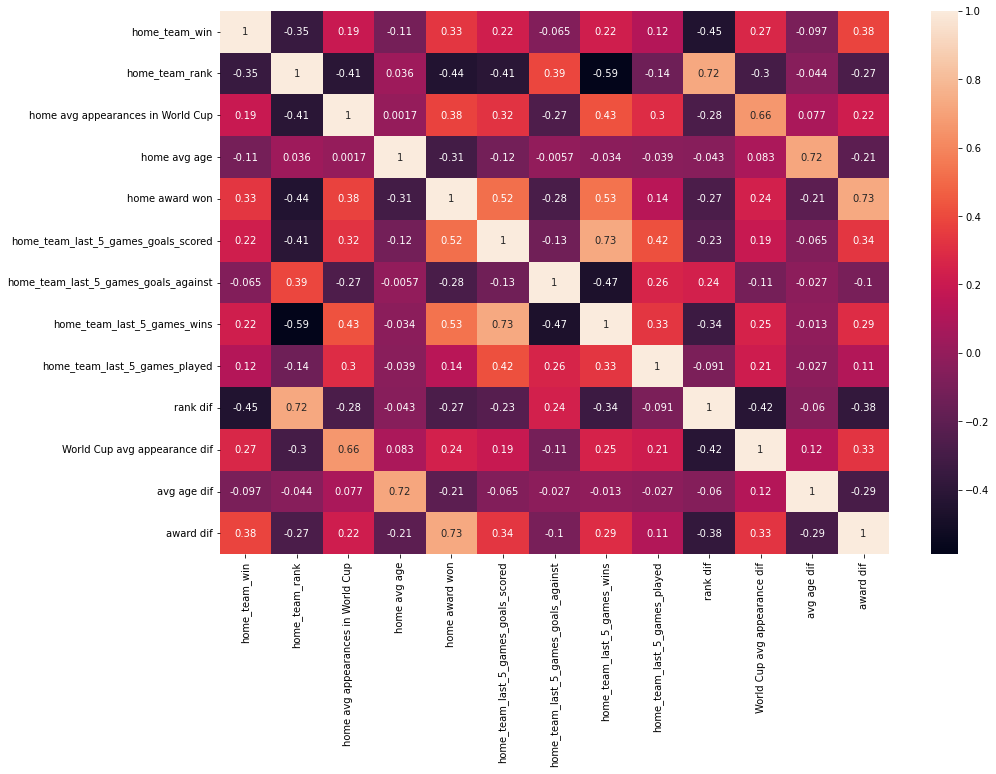

In [1209]:
plt.figure(figsize=(15, 10))
corr_matrix = all_teams_df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [1210]:
#here we assign draw and lost = 0, win = 1
y = all_teams_df['home_team_win']
X = all_teams_df[['home_team_rank', 'home avg appearances in World Cup', 'home avg age', 'home award won',
                 'home_team_last_5_games_goals_scored', 'home_team_last_5_games_goals_against',
                 'home_team_last_5_games_wins', 'home_team_last_5_games_played', 'rank dif',
                 'World Cup avg appearance dif', 'avg age dif', 'award dif']]

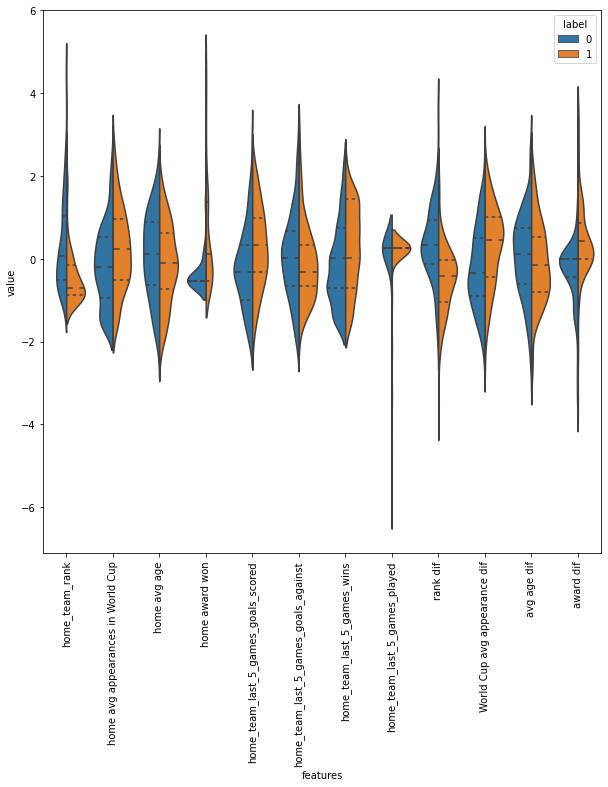

In [1211]:
X_z = X.astype(float)
X_z = (X_z - X_z.mean()) / X_z.std()
X_z['label'] = y
violin = pd.melt(X_z,id_vars="label", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="label", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

# Modeling 

## 1. Neural Network

In [1212]:
split_X = all_teams_df[["home_team_rank", "home avg appearances in World Cup",
                 "home avg age", "home award won", 
                 "home_team_last_5_games_goals_scored", 
                 "home_team_last_5_games_wins", "World Cup avg appearance dif", 
                 "avg age dif", "award dif"]]
split_Y = all_teams_df[["home_team_win"]]
X_train, X_test, Y_train, Y_test = train_test_split(split_X,
                                                    split_Y,
                                                    train_size = 0.9,
                                                    test_size = 0.1,
                                                    random_state = 42)

In [1213]:
# test accuracy for Neural Network model 
clf = MLPClassifier(hidden_layer_sizes=([51, 38]), max_iter = 171, 
                    activation = "logistic", solver = "lbfgs",
                    verbose = 1, random_state = 42)
clf.fit(X_train, Y_train)

print("Accuracy on train: ")
y_pred_train = clf.predict(X_train)
print(accuracy_score(Y_train, y_pred_train))

print("Accuracy on test: ")
y_pred_test = clf.predict(X_test)
print(accuracy_score(Y_test, y_pred_test))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2525     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19410D-01    |proj g|=  2.57014D-01

At iterate    1    f=  6.79873D-01    |proj g|=  2.10150D-02

At iterate    2    f=  6.78205D-01    |proj g|=  1.76383D-02

At iterate    3    f=  6.69439D-01    |proj g|=  2.08145D-02

At iterate    4    f=  6.55411D-01    |proj g|=  2.46657D-02

At iterate    5    f=  6.18820D-01    |proj g|=  8.86584D-02

At iterate    6    f=  5.95357D-01    |proj g|=  4.71854D-02

At iterate    7    f=  5.90273D-01    |proj g|=  4.37440D-02

At iterate    8    f=  5.86302D-01    |proj g|=  6.41948D-02

At iterate    9    f=  5.81384D-01    |proj g|=  2.84311D-02

At iterate   10    f=  5.77819D-01    |proj g|=  2.11574D-02

At iterate   11    f=  5.71666D-01    |proj g|=  4.53480D-02

At iterate   12    f=  5.69475D-01    |proj g|=  1.27960D-01

At iterate   13    f=  5.6

 This problem is unconstrained.



At iterate  121    f=  3.75866D-01    |proj g|=  7.78316D-02

At iterate  122    f=  3.75355D-01    |proj g|=  5.19548D-02

At iterate  123    f=  3.74932D-01    |proj g|=  3.09563D-02

At iterate  124    f=  3.74360D-01    |proj g|=  3.00802D-02

At iterate  125    f=  3.73501D-01    |proj g|=  3.46041D-02

At iterate  126    f=  3.72605D-01    |proj g|=  5.46156D-02

At iterate  127    f=  3.72101D-01    |proj g|=  5.00832D-02

At iterate  128    f=  3.71703D-01    |proj g|=  2.05437D-02

At iterate  129    f=  3.71179D-01    |proj g|=  3.13526D-02

At iterate  130    f=  3.70048D-01    |proj g|=  6.16842D-02

At iterate  131    f=  3.68332D-01    |proj g|=  1.19297D-01

At iterate  132    f=  3.67705D-01    |proj g|=  1.44335D-01

At iterate  133    f=  3.66410D-01    |proj g|=  9.31189D-02

At iterate  134    f=  3.65723D-01    |proj g|=  3.72308D-02

At iterate  135    f=  3.65190D-01    |proj g|=  3.90116D-02

At iterate  136    f=  3.64533D-01    |proj g|=  3.57948D-02

At iter

In [1214]:
# Find hyperparameter for MLP using Random Search Method
random_hidden_layer_list = []
random_max_iter = []
random_solver_list = []
max_score = accuracy_score(Y_test, y_pred_test)

hidden_layer_result = []
max_iter_result = 0
solver_result = "adam"
activation_result = ""

num_iters = 1000
for i in range(num_iters):
    random_hidden_layer_list.append([random.randint(1,100)])
    for j in range(random.randint(1, 3)):
        random_hidden_layer_list[i].append(random.randint(1,100))
    random_max_iter.append(random.randint(1,10) * random.randint(10, 50))
    k = random.randint(1,3)
    if k == 1:
        random_solver_list.append("lbfgs")
    elif k == 2:
        random_solver_list.append("sgd")
    else:
        random_solver_list.append("adam")
    clf = MLPClassifier(hidden_layer_sizes = random_hidden_layer_list[i], 
                        max_iter = random_max_iter[i], 
                        activation = "logistic", 
                        solver = random_solver_list[i],
                        random_state = 42)

    clf.fit(X_train, Y_train)
    y_pred_test = clf.predict(X_test)
    current_accuracy = accuracy_score(Y_test, y_pred_test)

    if (current_accuracy >= max_score):
        max_score = current_accuracy
        hidden_layer_result = random_hidden_layer_list[i]
        max_iter_result = random_max_iter[i]
        solver_result = random_solver_list[i]
    print("Iteration", i, 
        ", Accuracy on test: ", max_score, 
        ", hidden_layer: ", hidden_layer_result, 
        ", solver: ", solver_result,
        ", max_iter: ", max_iter_result,)
## Accuracy on test:  0.7922077922077922 , hidden_layer:  [37, 4] , solver:  adam , max_iter:  50
## Accuracy on test:  0.8051948051948052 , hidden_layer:  [86, 57] , solver:  lbfgs , max_iter:  205
## Accuracy on test:  0.8205128205128205 , hidden_layer:  [51, 38] , solver:  lbfgs , max_iter:  171

Iteration 0 , Accuracy on test:  0.7692307692307693 , hidden_layer:  [] , solver:  adam , max_iter:  0
Iteration 1 , Accuracy on test:  0.7692307692307693 , hidden_layer:  [] , solver:  adam , max_iter:  0
Iteration 2 , Accuracy on test:  0.7692307692307693 , hidden_layer:  [] , solver:  adam , max_iter:  0
Iteration 3 , Accuracy on test:  0.7692307692307693 , hidden_layer:  [] , solver:  adam , max_iter:  0
Iteration 4 , Accuracy on test:  0.7692307692307693 , hidden_layer:  [] , solver:  adam , max_iter:  0
Iteration 5 , Accuracy on test:  0.7692307692307693 , hidden_layer:  [] , solver:  adam , max_iter:  0
Iteration 6 , Accuracy on test:  0.7692307692307693 , hidden_layer:  [] , solver:  adam , max_iter:  0
Iteration 7 , Accuracy on test:  0.7692307692307693 , hidden_layer:  [100, 19] , solver:  adam , max_iter:  40
Iteration 8 , Accuracy on test:  0.7692307692307693 , hidden_layer:  [100, 19] , solver:  adam , max_iter:  40
Iteration 9 , Accuracy on test:  0.7692307692307693 , hid

Iteration 73 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [76, 97, 54, 83] , solver:  adam , max_iter:  294
Iteration 74 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [76, 97, 54, 83] , solver:  adam , max_iter:  294
Iteration 75 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [76, 97, 54, 83] , solver:  adam , max_iter:  294
Iteration 76 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [76, 97, 54, 83] , solver:  adam , max_iter:  294
Iteration 77 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [76, 97, 54, 83] , solver:  adam , max_iter:  294
Iteration 78 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [76, 97, 54, 83] , solver:  adam , max_iter:  294
Iteration 79 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [76, 97, 54, 83] , solver:  adam , max_iter:  294
Iteration 80 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [76, 97, 54, 83] , solver:  adam , max_iter:  294
Iteration 81 , Accuracy on test:  0.7948

Iteration 145 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [75, 88, 36] , solver:  adam , max_iter:  368
Iteration 146 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [75, 88, 36] , solver:  adam , max_iter:  368
Iteration 147 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [75, 88, 36] , solver:  adam , max_iter:  368
Iteration 148 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [75, 88, 36] , solver:  adam , max_iter:  368
Iteration 149 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [75, 88, 36] , solver:  adam , max_iter:  368
Iteration 150 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [75, 88, 36] , solver:  adam , max_iter:  368
Iteration 151 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [75, 88, 36] , solver:  adam , max_iter:  368
Iteration 152 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [75, 88, 36] , solver:  adam , max_iter:  368
Iteration 153 , Accuracy on test:  0.7948717948717948 , hidden_l

Iteration 215 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [49, 81, 84, 69] , solver:  lbfgs , max_iter:  80
Iteration 216 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [49, 81, 84, 69] , solver:  lbfgs , max_iter:  80
Iteration 217 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [49, 81, 84, 69] , solver:  lbfgs , max_iter:  80
Iteration 218 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [49, 81, 84, 69] , solver:  lbfgs , max_iter:  80
Iteration 219 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [49, 81, 84, 69] , solver:  lbfgs , max_iter:  80
Iteration 220 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [49, 81, 84, 69] , solver:  lbfgs , max_iter:  80
Iteration 221 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [49, 81, 84, 69] , solver:  lbfgs , max_iter:  80
Iteration 222 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [49, 81, 84, 69] , solver:  lbfgs , max_iter:  80
Iteration 223 , Accuracy on test

Iteration 285 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [45, 45, 15, 43] , solver:  adam , max_iter:  322
Iteration 286 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [32, 28, 45] , solver:  lbfgs , max_iter:  72
Iteration 287 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [32, 28, 45] , solver:  lbfgs , max_iter:  72
Iteration 288 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [32, 28, 45] , solver:  lbfgs , max_iter:  72
Iteration 289 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [32, 28, 45] , solver:  lbfgs , max_iter:  72
Iteration 290 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [32, 28, 45] , solver:  lbfgs , max_iter:  72
Iteration 291 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [32, 28, 45] , solver:  lbfgs , max_iter:  72
Iteration 292 , Accuracy on test:  0.7948717948717948 , hidden_layer:  [32, 28, 45] , solver:  lbfgs , max_iter:  72
Iteration 293 , Accuracy on test:  0.7948717948717948 , hidd

Iteration 355 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 356 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 357 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 358 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 359 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 360 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 361 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 362 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 363 , Accuracy on test

Iteration 423 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 424 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 425 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 426 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 427 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 428 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 429 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 430 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 431 , Accuracy on test

Iteration 491 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 492 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 493 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 494 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 495 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 496 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 497 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 498 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 499 , Accuracy on test

Iteration 560 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 561 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 562 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 563 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 564 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 565 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 566 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 567 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 568 , Accuracy on test

Iteration 628 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 629 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 630 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 631 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 632 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 633 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 634 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 635 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 636 , Accuracy on test

Iteration 696 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 697 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 698 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 699 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 700 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 701 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 702 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 703 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 704 , Accuracy on test

Iteration 765 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 766 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 767 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 768 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 769 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 770 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 771 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 772 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 773 , Accuracy on test

Iteration 835 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 836 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 837 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 838 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 839 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 840 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 841 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 842 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 843 , Accuracy on test

Iteration 903 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 904 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 905 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 906 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 907 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 908 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 909 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 910 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 911 , Accuracy on test

Iteration 971 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 972 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 973 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 974 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 975 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 976 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 977 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 978 , Accuracy on test:  0.8205128205128205 , hidden_layer:  [62, 73, 52, 17] , solver:  adam , max_iter:  500
Iteration 979 , Accuracy on test

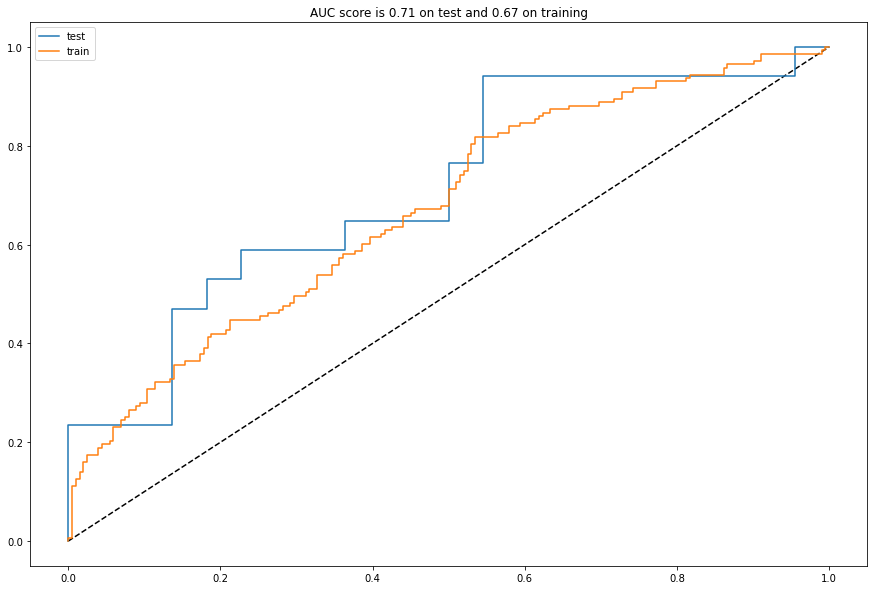

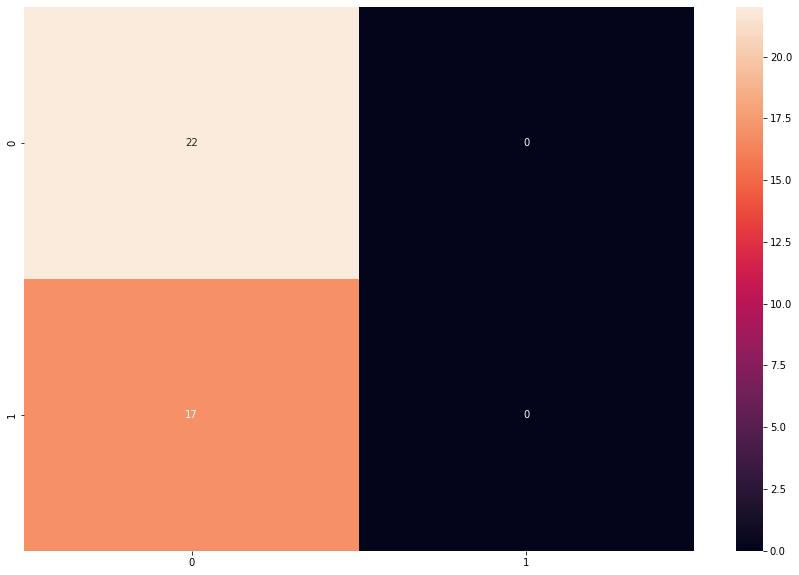

In [1215]:
# Apply ROC curve and confusion matrix
y_actual = np.array(Y_test)

sum(y_pred_test == y_actual)/len(y_actual)

fpr, tpr, _ = roc_curve(Y_test, clf.predict_proba(X_test)[:,1]) #test AUC
plt.figure(figsize=(15,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="test")

fpr_train, tpr_train, _ = roc_curve(Y_train, clf.predict_proba(X_train)[:,1]) #train AUC
plt.plot(fpr_train, tpr_train, label="train")
auc_test = roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1])
auc_train = roc_auc_score(Y_train, clf.predict_proba(X_train)[:,1])
plt.legend()
plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
plt.show()

plt.figure(figsize=(15, 10))
cm = confusion_matrix(Y_test, clf.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d");

## 1. Random Forest

In [1216]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size= 0.1, random_state=42)

rf = RandomForestClassifier(random_state=42)

params = {"max_depth": [20, 10],
        "min_samples_split": [2, 5],
        "max_leaf_nodes": [175, 100],
        "min_samples_leaf": [5, 3],
        "n_estimators": [100, 200],
         "max_features": ["sqrt", "log2"],
        }

rf_cv = GridSearchCV(rf, params, cv = 5, verbose=2)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=5, min_samples_spli

[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=2

[CV] END max_depth=20, max_features=log2, max_leaf_nodes=175, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=20, max_features=log2, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=log2, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=log2, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=log2, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=log2, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=log2, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=2

[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=175, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=1

[CV] END max_depth=10, max_features=sqrt, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=175, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=1

[CV] END max_depth=10, max_features=log2, max_leaf_nodes=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=1

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [20, 10],
                         'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [175, 100],
                         'min_samples_leaf': [5, 3],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [1217]:
rf = rf_cv.best_estimator_

In [1218]:
y_predicted_result = rf.predict(X_test)
y_actual = np.array(y_test)
#predict_proba

In [1219]:
#first trial test set accuracy 0.82, randomseed 42
sum(y_predicted_result == y_actual)/len(y_actual)

0.8205128205128205

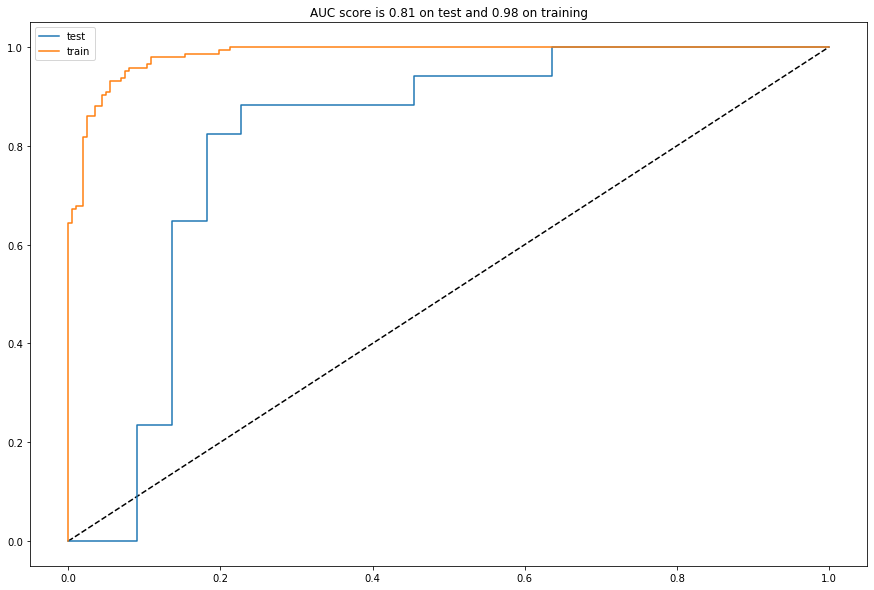

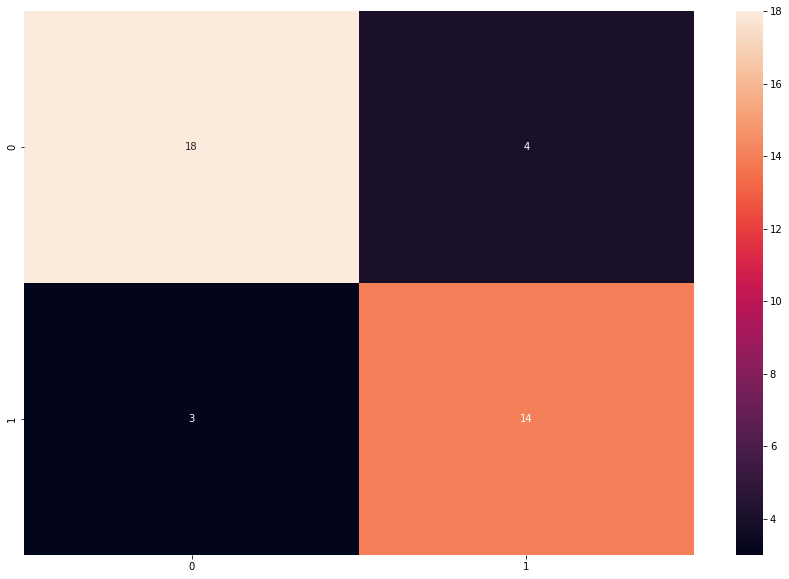

In [1220]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1]) #test AUC
plt.figure(figsize=(15,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="test")

fpr_train, tpr_train, _ = roc_curve(y_train, rf.predict_proba(X_train)[:,1]) #train AUC
plt.plot(fpr_train, tpr_train, label="train")
auc_test = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
auc_train = roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])
plt.legend()
plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
plt.show()

plt.figure(figsize=(15, 10))
cm = confusion_matrix(y_test, rf.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d");

# World Cup 2022 Simulation

## 1. Set up test dataset

In [1221]:
home_team_name_array = np.array(['Qatar','England', 'Senegal', 'United States', 'Argentina', 'Denmark', 'Mexico', 'France', 'Morocco',
                                 'Germany', 'Spain', 'Belgium', 'Switzerland', 'Uruguay', 'Portugal', 'Brazil', 'Wales', 'Qatar',
                                 'Netherlands', 'England', 'Tunisia','Poland', 'France', 'Argentina', 'Japan', 'Belgium', 'Croatia',
                                 'Spain', 'Cameroon', 'South Korea', 'Brazil', 'Portugal', 'Ecuador', 'Netherlands', 'Iran', 'Wales',
                                 'Tunisia', 'Australia', 'Poland', 'Saudi Arabia', 'Croatia', 'Canada','Japan', 'Costa Rica',
                                 'South Korea', 'Ghana', 'Serbia', 'Cameroon']  )

away_team_name_array = np.array(['Ecuador', 'Iran', 'Netherlands', 'Wales', 'Saudi Arabia', 'Tunisia', 'Poland', 'Australia', 'Croatia',
                                 'Japan', 'Costa Rica', 'Canada', 'Cameroon', 'South Korea', 'Ghana', 'Serbia', 'Iran', 'Senegal',
                                 'Ecuador', 'United States', 'Australia', 'Saudi Arabia', 'Denmark','Mexico','Costa Rica', 'Morocco', 'Canada',
                                 'Germany', 'Serbia', 'Ghana', 'Switzerland', 'Uruguay', 'Senegal', 'Qatar', 'United States', 'England', 'France',
                                 'Denmark', 'Argentina', 'Mexico', 'Belgium', 'Morocco', 'Spain', 'Germany', 'Portugal', 'Uruguay',
                                 'Switzerland', 'Brazil'])

ranking_2022 = ranking[ranking['year'] == '2022']

home_team_name_rank = pd.DataFrame()
home_team_name_rank['home_team_name'] = home_team_name_array
home_team_name_rank = home_team_name_rank.merge(ranking_2022, how = "left", left_on = 'home_team_name', right_on = 'country_full')
home_team_name_rank = home_team_name_rank.loc[:, ['home_team_name', 'rank']]

away_team_name_rank = pd.DataFrame()
away_team_name_rank['away_team_name'] = away_team_name_array
away_team_name_rank = away_team_name_rank.merge(ranking_2022, how = "left", left_on = 'away_team_name', right_on = 'country_full')
away_team_name_rank = away_team_name_rank.loc[:, ['away_team_name', 'rank']]

player_stats_df = pd.read_csv("dataset_2022/player/player_stats.csv")
player_team = player_stats_df.loc[:,['player', 'team', 'age']]
player_team['age_year'] = [int(x[:2]) for x in player_team['age']]
player_df['full_name'] = player_df['given_name'] + ' ' + player_df['family_name']
player_team = player_team.merge(player_df, how = 'left', left_on = 'player', right_on = 'full_name')
team_age_df = player_team.groupby(['team'])[['age_year']].mean().reset_index()
player_team = player_team.fillna(0)
player_team = player_team.groupby(['team']).agg({'total appearances in World Cup':'mean',
                                                 'award_won': 'sum'})
player_team = player_team.merge(team_age_df, how = 'left', left_on = 'team', right_on = 'team')
player_team["team"] = player_team["team"].replace("IR Iran", "Iran").replace("Korea Republic", "South Korea").replace("USA", "United States").replace("Côte d'Ivoire", 'Ivory Coast').replace('Korea DPR', 'North Korea')

home_name_rank_appear_age_award = home_team_name_rank.merge(player_team, how = 'left', left_on = 'home_team_name', right_on = 'team')
home_name_rank_appear_age_award = home_name_rank_appear_age_award.fillna(0)
home_name_rank_appear_age_award = home_name_rank_appear_age_award.drop('team', axis=1)

away_name_rank_appear_age_award = away_team_name_rank.merge(player_team, how = 'left', left_on = 'away_team_name', right_on = 'team')
away_name_rank_appear_age_award = away_name_rank_appear_age_award.fillna(0)
away_name_rank_appear_age_award = away_name_rank_appear_age_award.drop('team', axis=1)

home_goal_scored_2022 = []
home_goal_against_2022 = []
home_wins_2022 = []
home_previous_games_count_max_5_2022 = []

for i in range(len(home_team_name_rank)):
    test_team = home_team_name_rank['home_team_name'][i]
    prev_matches = matches_sorted.loc[(matches_sorted['home_team_name'] == test_team) |
                               (matches_sorted['away_team_name'] == test_team), :]

    
    if len(prev_matches) == 0:
        home_goal_scored_2022.append(0)
        home_goal_against_2022.append(0)
        home_wins_2022.append(0)
        home_previous_games_count_max_5_2022.append(0)
        
    else:
        last_5 = prev_matches.tail(5)
        home_previous_games_count_max_5_2022.append(len(last_5))
        
        home_team_index = last_5['home_team_name'] == test_team
        away_team_index = last_5['away_team_name'] == test_team
        
        last_5_away = last_5.loc[away_team_index, :]
        if len(last_5_away) == 0:
            last_5_away = np.array([0, 0, 0])
        else:
            last_5_away = last_5_away.groupby('away_team_name')['away_team_score', 'home_team_score',
                                                        'away_team_win'].sum().to_numpy()[0]
        last_5_home = last_5.loc[home_team_index, :]
        if len(last_5_home) == 0:
            last_5_home = np.array([0, 0, 0])
        else:
            last_5_home = last_5_home.groupby('home_team_name')['home_team_score', 'away_team_score',
                                                        'home_team_win'].sum().to_numpy()[0]

        results = last_5_home + last_5_away

        home_goal_scored_2022.append(results[0])
        home_goal_against_2022.append(results[1])
        home_wins_2022.append(results[2])
        
home_name_rank_appear_age_award['home_team_last_5_games_goals_scored_2022'] = home_goal_scored_2022
home_name_rank_appear_age_award['home_team_last_5_games_goals_against_2022'] = home_goal_against_2022
home_name_rank_appear_age_award['home_team_last_5_games_wins_2022'] = home_wins_2022
home_name_rank_appear_age_award['home_team_last_5_games_played_2022'] = home_previous_games_count_max_5_2022

away_goal_scored_2022 = []
away_goal_against_2022 = []
away_wins_2022 = []
away_previous_games_count_max_5_2022 = []

for i in range(len(away_team_name_rank)):
    test_team = start_goal['away_team_name'][i]
    prev_matches = matches_sorted.loc[(matches_sorted['home_team_name'] == test_team) |
                               (matches_sorted['away_team_name'] == test_team), :]

    
    if len(prev_matches) == 0:
        away_goal_scored_2022.append(0)
        away_goal_against_2022.append(0)
        away_wins.append(0)
        away_previous_games_count_max_5_2022.append(0)
        
    else:
        last_5 = prev_matches.tail(5)
        away_previous_games_count_max_5_2022.append(len(last_5))
        
        home_team_index = last_5['home_team_name'] == test_team
        away_team_index = last_5['away_team_name'] == test_team
        
        last_5_away = last_5.loc[away_team_index, :]
        if len(last_5_away) == 0:
            last_5_away = np.array([0, 0, 0])
        else:
            last_5_away = last_5_away.groupby('away_team_name')['away_team_score', 'home_team_score',
                                                        'away_team_win'].sum().to_numpy()[0]
        last_5_home = last_5.loc[home_team_index, :]
        if len(last_5_home) == 0:
            last_5_home = np.array([0, 0, 0])
        else:
            last_5_home = last_5_home.groupby('home_team_name')['home_team_score', 'away_team_score',
                                                        'home_team_win'].sum().to_numpy()[0]

        results = last_5_home + last_5_away

        away_goal_scored_2022.append(results[0])
        away_goal_against_2022.append(results[1])
        away_wins_2022.append(results[2])
        
away_name_rank_appear_age_award['away_team_last_5_games_goals_scored_2022'] = away_goal_scored_2022
away_name_rank_appear_age_award['away_team_last_5_games_goals_against_2022'] = away_goal_against_2022
away_name_rank_appear_age_award['away_team_last_5_games_wins_2022'] = away_wins_2022
away_name_rank_appear_age_award['away_team_last_5_games_played_2022'] = away_previous_games_count_max_5_2022

home_dif = home_name_rank_appear_age_award.iloc[:, 1:5]
away_dif = away_name_rank_appear_age_award.iloc[:, 1:5]

home_actual_dif = home_dif-away_dif
away_actual_dif = away_dif -home_dif

home_final = pd.concat([home_name_rank_appear_age_award, home_actual_dif], axis=1)
away_final = pd.concat([away_name_rank_appear_age_award, away_actual_dif], axis=1)


In [1222]:
#read 2022 test data
fifa_2022_home = home_final
fifa_2022_away = away_final
fifa_2022_away_X = fifa_2022_away.iloc[:, 1:].to_numpy()
fifa_2022_home_X = fifa_2022_home.iloc[:, 1:].to_numpy()

## 2.Group Stage

In [1223]:
home_group_status = rf.predict(fifa_2022_home_X)
away_group_status = rf.predict(fifa_2022_away_X)

def result(home, away):
    if ((home == 1) and (away == 1)) or ((home == 0) and (away == 0)):
        return 'tie'
    if (home == 1) and (away == 0):
        return 'home win'
    if (home == 0) and (away == 1):
        return 'home lose'

real_group_stage_result = ["home lose", 'home win', 'home lose', 'tie', 'home lose', 'tie', 'tie', 'home win', 'tie',
                          'home lose', 'home win', 'home win', 'home win', 'tie', 'home win', 'home win', 'home lose',
                          'home lose', 'tie', 'tie', 'home lose', 'home win', 'home win', 'home win', 'home lose',
                           'home lose', 'home win', 'tie', 'tie', 'home lose', 'home win', 'home win', 'home lose',
                          'home win', 'home lose', 'home lose', 'home win', 'home win', 'home lose', 'home lose',
                          'tie', 'home lose', 'home win', 'home lose', 'home win', 'home lose', 'home lose', 'home win']

result_group_stage = []
for i in range(48):
    result_group_stage.append(result(home_group_status[i], away_group_status[i]))

df_test = pd.concat([fifa_2022_home[['home_team_name']], fifa_2022_away[['away_team_name']],
           pd.Series(result_group_stage), pd.Series(real_group_stage_result)], axis=1) 
df_test.head(5)

,home_team_name,away_team_name,0,1
0,Qatar,Ecuador,home win,home lose
1,England,Iran,home win,home win
2,Senegal,Netherlands,home lose,home lose
3,United States,Wales,tie,tie
4,Argentina,Saudi Arabia,home win,home lose


## 3.Knockout Rounds

In [1224]:
def team_process(home_name, away_name):
    home_df = pd.DataFrame()
    away_df = pd.DataFrame()
    fifa_2022_nodif = fifa_2022_home.iloc[:,:-4].drop_duplicates()

    home_df['home_team_name'] = home_name
    away_df['away_team_name'] = away_name

    home_df = home_df.merge(fifa_2022_nodif, how = 'left', left_on = 'home_team_name', right_on = 'home_team_name')

    away_df = away_df.merge(fifa_2022_nodif, how = 'left', left_on = 'away_team_name', right_on = 'home_team_name')
    away_df = away_df.drop('home_team_name', axis = 1)
    
    home_df['rank dif'] = home_df['rank'] - away_df['rank']
    home_df['World Cup avg appearance dif'] = home_df['total appearances in World Cup'] - away_df['total appearances in World Cup']
    home_df['avg age dif'] = home_df['age_year'] - away_df['age_year']
    home_df['award dif'] = home_df['award_won'] - away_df['award_won']

    away_df['rank dif'] = - (home_df['rank'] - away_df['rank'])
    away_df['World Cup avg appearance dif'] = - (home_df['total appearances in World Cup'] - away_df['total appearances in World Cup'])
    away_df['avg age dif'] = - (home_df['age_year'] - away_df['age_year'])
    away_df['award dif'] = - (home_df['award_won'] - away_df['award_won'])
    
    away_X = away_df.iloc[:, 1:].to_numpy()
    home_X = home_df.iloc[:, 1:].to_numpy()

    home_predict = rf.predict(home_X)
    away_predict = rf.predict(away_X)
    home_prob = rf.predict_proba(home_X)[:,1]
    away_prob = rf.predict_proba(away_X)[:,1]
    
    
    df_test = pd.concat([home_df[['home_team_name']], pd.Series(home_predict), pd.Series(home_prob),
                             away_df[['away_team_name']], pd.Series(away_predict), pd.Series(away_prob)],
                            axis=1)
    return df_test

R16_home_name_array = np.array(['Netherlands', 'England', 'Argentina', 'France','Germany', 'Belgium','Brazil', 'Uruguay'])
R16_away_name_array = np.array(['Iran', 'Senegal', 'Denmark', 'Mexico', 'Croatia', 'Spain', 'Portugal', 'Switzerland'])

df_R16_test = team_process(R16_home_name_array, R16_away_name_array)

QF_home_name_array = np.array(['Netherlands', 'England',  'Germany', 'Belgium'])
QF_away_name_array = np.array(['Argentina', 'France', 'Brazil', 'Uruguay'])

df_QF_test = team_process(QF_home_name_array, QF_away_name_array)

SF_home_name_array = np.array(['Argentina', 'France'])
SF_away_name_array = np.array(['Germany', 'Belgium'])

df_SF_test = team_process(SF_home_name_array, SF_away_name_array)

F_home_name_array = np.array(['Germany', 'Argentina'])
F_away_name_array = np.array(['Belgium', 'France'])

df_F_test = team_process(F_home_name_array, F_away_name_array)

In [1225]:
df_F_test

,home_team_name,0,1,away_team_name,2,3
0,Germany,0,0.458318,Belgium,1,0.641846
1,Argentina,0,0.365282,France,1,0.695000


In [1226]:
#1st place: Belgium, 2nd place: Germany, 3rd place: France, 4th place: Argentina